# **LSTM-Stock Prediction**
## Import the necessary libraries

In [ ]:
!pip install pandas_datareader==0.9.0
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: pandas_datareader
    Found existing installation: pandas-datareader 0.10.0
    Uninstalling pandas-datareader-0.10.0:
      Successfully uninstalled pandas-datareader-0.10.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import datetime as dt

## Specifies the stock symbol number for the prediction
If you want to predict the stock in US market, type:
`company='the name of the company' `

for exmaple: `company='AAPL' #which stands for Apple `

In [3]:
#The specifies stock symbol for a Taiwanese company.
company = '2002.TW'

data_start= dt.datetime(2020,1,1)
data_end = dt.datetime(2024,2,29)

#Download the data from yahoo finance
data = yf.download(company, data_start, data_end)
print(data.head(5))
print(data.tail(5))


[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-01-02  24.000000  24.100000  23.900000  24.000000  20.218719   6939981
2020-01-03  24.049999  24.100000  23.950001  24.100000  20.302965  12353288
2020-01-06  24.000000  24.049999  23.799999  23.799999  20.050230   7042674
2020-01-07  23.799999  23.900000  23.700001  23.700001  19.965988   7693624
2020-01-08  23.700001  23.700001  23.500000  23.549999  19.839621   9093876
                 Open       High    Low  Close  Adj Close    Volume
Date                                                               
2024-02-21  25.299999  25.299999  25.15  25.25      25.25   9525441
2024-02-22  25.250000  25.299999  25.10  25.15      25.15   9676925
2024-02-23  25.150000  25.200001  25.00  25.00      25.00  11649661
2024-02-26  24.900000  25.000000  24.90  24.90      24.90  11512246
2024-02-27  24.799999  24.799999  24.60  24.65      24.65  2

In [4]:
##Determine the columns(the input/parameter you want for prediction) of the data##
df=data[['Close']]
print(df.head())
print(f'df_shape{df.shape}')

                Close
Date                 
2020-01-02  24.000000
2020-01-03  24.100000
2020-01-06  23.799999
2020-01-07  23.700001
2020-01-08  23.549999
df_shape(1007, 1)


Text(0.5, 1.0, 'Stock Price Over Time')

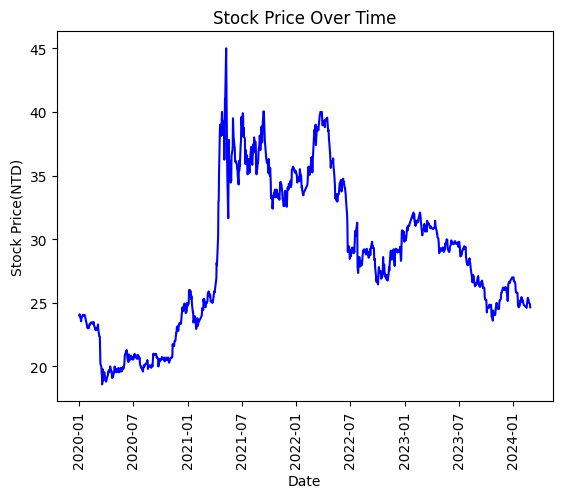

In [5]:
#Print the plot for visualization
plt.plot(df, color="blue")
plt.tick_params(axis ='x', rotation = 90)
plt.xlabel('Date')  # Add x-axis label
plt.ylabel('Stock Price(NTD)')  # Add y-axis label
plt.title('Stock Price Over Time')  # Add plot title


#Data Preprocessing

*   **MinMaxScaler:**
MinMaxScaler is one of the data preprocessing technique, it scales the features into a range from 0 to 1, which could increase the speed when the model computing the data, instead of computing a bunch of large integers during training, the formula can be represented as the following equation.

\begin{align}
 X_{\text{scaled}}= \frac{{X - X_{\text{min}}}}{{X_{\text{max}} - X_{\text{min}}}}
\end{align}

where:
- $X$ is the original feature value,
- $X_{\text{min}}$ is the minimum value of the feature,
- $X_{\text{max}}$ is the maximum value of the feature,
- $X_{\text{scaled}}$ is the after scaled value.


In [6]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
##Scale the data##
df_scaler = MinMaxScaler(feature_range =(0,1))
df_scaled = df_scaler.fit_transform(df)

print(df_scaled[:5])
print(f'df_scaled_shape{df_scaled.shape}')


[[0.20454544]
 [0.20833334]
 [0.19696966]
 [0.19318184]
 [0.18749996]]
df_scaled_shape(1007, 1)


#Spilt the data
To split the stock price data into training and testing sets, we're using a **Time Series** approach instead of a random split.

In this project, the `train_split` is set to 70%, and 30% for the `test_split`

In [8]:
print(len(df_scaled))

train_split = int(0.7 * len(df_scaled))
test_split = int(0.3 * len(df_scaled))

print(train_split)
print(test_split)

1007
704
302


In [9]:
# Split the data into training and testing sets based on the split date
train_data = df_scaled[:train_split]
test_data=df_scaled[train_split:]

# print(train_data)
print(len(train_data))
print(len(test_data))

print(f'train_data:{train_data[:5]}')
print(f'test_data:{test_data[:5]}')

704
303
train_data:[[0.20454544]
 [0.20833334]
 [0.19696966]
 [0.19318184]
 [0.18749996]]
test_data:[[0.39393939]
 [0.39393939]
 [0.39393939]
 [0.40151517]
 [0.38446969]]


#Time step in LSTM
In this project, the prediction days is set to 5 days,
`prediction_days = 5`, which means that the model will predict the next day's stock price, based on the past 5 days.



*   **Smaller time step(e.g., 3d days):** Caputure the short-term trend, but it may be less stable and more sensitive to noise in the data.
*   **Larger time step(e.g., 10d days):** Caputure the long-term trend, but it may be less sensitive to the data, and missed the important sign in the trend.



In [10]:
#Set up the time step
prediction_days = 5

##train_data##
x_train = []
y_train = []
#so the x will start from 5, from 5 to the len of train_data
for x in range(prediction_days, len(train_data)):
  x_train.append(train_data[x-prediction_days:x,0:])
  y_train.append(train_data[x,0])

##test_data##
x_test = []
y_test = []

for x in range(prediction_days, len(test_data)):
  x_test.append(test_data[x-prediction_days:x,0:])
  y_test.append(test_data[x,0])

print (x_train[:2])
print (y_train[:2])

print (x_test[:2])
print (y_test[:2])
print(type(x_train))
print(type(y_train))


[array([[0.20454544],
       [0.20833334],
       [0.19696966],
       [0.19318184],
       [0.18749996]]), array([[0.20833334],
       [0.19696966],
       [0.19318184],
       [0.18749996],
       [0.19507575]])]
[0.19507574594491528, 0.19886363923713857]
[array([[0.39393939],
       [0.39393939],
       [0.39393939],
       [0.40151517],
       [0.38446969]]), array([[0.39393939],
       [0.39393939],
       [0.40151517],
       [0.38446969],
       [0.3522727 ]])]
[0.352272703463709, 0.3825757775534395]
<class 'list'>
<class 'list'>


In [11]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

699
699
298
298


#Specific format of the data for feeding into LSTM
LSTM models expect input data in a specific format, usually in the shape (samples, time steps, features)


In [12]:
#Turns the List into Numpy array to feed into the LSTM model.
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

# (number_of_samples, number_of_time_steps, number_of_features)
print(f'x_train.shape{x_train.shape}')
print(f"y_train.shape{y_train.shape}")

print(f"x_test.shape{x_test.shape}")
print(f"y_test.shape{y_test.shape}")

print(type(x_train))
print(type(y_train))

x_train.shape(699, 5, 1)
y_train.shape(699,)
x_test.shape(298, 5, 1)
y_test.shape(298,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


#LSTM
### Model Architecture

*   **First layer**: have 150 neurons, with input parameter, and a returning sequences (output for each time step), with an activation function as 'relu'
*   **Second layer**: have 150 neurons, returning sequences (output for each time step), using ReLU activation function.
*   **Third layer**: have 150 neurons, not returning sequences (output only at the last time step), using ReLU activation function.
*   **Final/Output layer**: have 1 neurons, due to there is only 1 expecting output for this model prediction, using Linear activation function.
*   **Dropout layer**: Dropout layers are added after each LSTM layer to prevent overfitting.

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam,SGD

Epoch 1/100
35/35 [==============================] - 14s 82ms/step - loss: 0.0723 - val_loss: 0.0020
Epoch 2/100
35/35 [==============================] - 2s 49ms/step - loss: 0.0093 - val_loss: 0.0012
Epoch 3/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0058 - val_loss: 4.8939e-04
Epoch 4/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0049 - val_loss: 4.0963e-04
Epoch 5/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0047 - val_loss: 7.0918e-04
Epoch 6/100
35/35 [==============================] - 1s 26ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 7/100
35/35 [==============================] - 2s 46ms/step - loss: 0.0047 - val_loss: 4.8249e-04
Epoch 8/100
35/35 [==============================] - 1s 42ms/step - loss: 0.0048 - val_loss: 8.2615e-04
Epoch 9/100
35/35 [==============================] - 1s 25ms/step - loss: 0.0044 - val_loss: 4.4223e-04
Epoch 10/100
35/35 [==============================] - 1s 26ms/step - loss: 

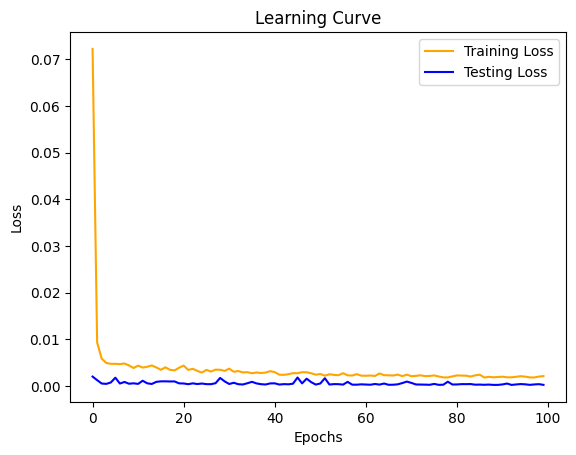

In [14]:
###LSTM model

# input shape=(times step, input features)
model = Sequential()
model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]), activation='relu'))
model.add(Dropout(0.1))
model.add(LSTM(units=150, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

#After the analysis for the model performance, The optimizer of Adam and 20batch, 100epochs have the lowest loss
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
history=model.fit(x_train, y_train, validation_data=(x_test, y_test),
          batch_size=20, epochs=100, verbose=1)

#Store the loss
train_loss=history.history['loss']
test_loss=history.history['val_loss']

#plot learning rate for train and test data
plt.plot(train_loss, label='Training Loss', color='orange')
plt.plot(test_loss, label='Testing Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


#Evaluation Metrics

**1. MSE(Mean Square Error):**


*   An evaluation metrics which suitable for the **regression problem**.
*   The smaller value of the MSE, indicates the better performance of the model, as they represent an error with the actual and predict output.
*   MSE could be shown as the following equation, where ${n}$ represent the number of data points;  ${y_i}$ represent the actual output,  $\hat{y_i}$ represent the predict output.

\begin{align}
 \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
\end{align}


**2. R-squared:**
*   R-squared value is commonly range from 0 to 1, which could be understand as from 0% to 100%.
*   Commonly, the higher value of R-square indicated a better model fits, but its still need to depend on what or which data/problem that the model is dealing with.
*   R-squared could be shown as the following equation, where ${SSR}$ is the sum of squared residuals (errors) and ${SST}$ is the total sum of squares (variation in the target).
\begin{align}
 \text{R}^2 = 1-\frac{SSR}{SST}
\end{align}



In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


# Model prediction for training data


* After training the model and making predictions on the training data, an evaluation of the model's performance was conducted. The Mean Squared Error (MSE) for the training set was calculated to be 0.00075, while the R-squared (R²) value reached 0.988. These metrics demonstrate that the model achieved approximately 98% accuracy in predicting the actual values.

* The plot depicts the alignment between the predicted values (red line) and the actual data (black line) for the training set. The close alignment indicates that the model was trained effectively and can make precise predictions.


22/22 [==============================] - 1s 28ms/step
mse_train:0.0007025904744096399
r2_train:0.989401285819542

prediction_train:[[0.19172291]]
y_orig_train:[0.19507575]
prediction_train.shape:(699, 1)
y_train.shape:(699,)

y_train_reshape.shape:(699, 1)

prediction_train_scaled:[[23.661484]]
y_train_scaled:[[23.75]]


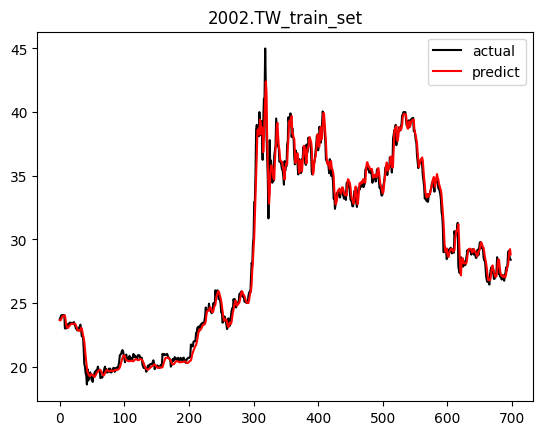

In [22]:
#Model make prediction for training data
prediction_train=model.predict(x_train)
mse_train=mean_squared_error(y_train, prediction_train)
r_square_train= r2_score(y_train, prediction_train)

#Evalue the performance of the training set
print(f'mse_train:{mse_train}')
print(f'r2_train:{r_square_train}\n')

#See the data value before scaling back to the orig scale
print(f"prediction_train:{prediction_train[:1]}")
print(f"y_orig_train:{y_train[:1]}")

#Check the shape
print(f"prediction_train.shape:{prediction_train.shape}")
print(f"y_train.shape:{y_train.shape}\n")

#reshape y_train in order to plot the data
y_train_reshape=y_train.reshape(-1,1)
print(f"y_train_reshape.shape:{y_train_reshape.shape}\n")

#Scale the data to the orig value
prediction_train_scaled=df_scaler.inverse_transform(prediction_train)
y_train_scaled=df_scaler.inverse_transform(y_train_reshape)
print(f"prediction_train_scaled:{prediction_train_scaled[:1]}")
print(f"y_train_scaled:{y_train_scaled[:1]}")

#Plot the data
plt.plot(y_train_scaled, color='black', label=f'actual')
plt.plot(prediction_train_scaled, color='red', label=f'predict')
plt.title(f"2002.TW_train_set")
plt.legend()

# plt.xlim(990, 1000)  # Set the limits for the x-axis
# plt.ylim(100, 300)  # Set the limits for the y-axis

plt.show()

#Prediction for **test data**

* The Mean Squared Error (MSE) for the test set was calculated to be 0.0002, while the R-squared (R²) value reached 0.974. These metrics demonstrate that the model achieved approximately 97% accuracy in predicting the actual values in the test set.

* The plot depicts the alignment between the predicted values (red line) and the actual data (black line) for the **test** set. The close alignment indicates that the model was trained effectively and can make precise predictions.


10/10 [==============================] - 0s 21ms/step
prediction:[[0.39487505]]
y_test:[0.3522727]

mse_test:0.0002025810395371336
r_square_test:0.9747219559509257

prediction.shape:(298, 1)
y_test.shape:(298,)

y_test_reshape.shape:(298, 1)

y_test_prediction:[[29.024702]]
y_test_scaled:[[27.89999962]]


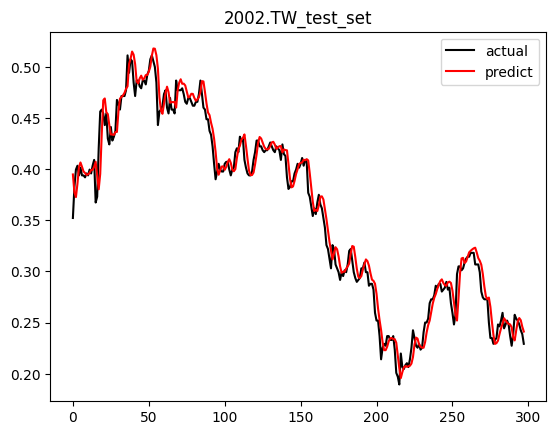

In [24]:
#Model make prediction for test set
prediction=model.predict(x_test)

print(f"prediction:{prediction[:1]}")
print(f"y_test:{y_test[:1]}\n")

#Evaluate the model prediction of the test set
mse_test=mean_squared_error(y_test, prediction)
r_square_test= r2_score(y_test, prediction)
print(f'mse_test:{mse_test}')
print(f'r_square_test:{r_square_test}\n')

#Check the shape
print(f"prediction.shape:{prediction.shape}")
print(f"y_test.shape:{y_test.shape}\n")

#Reshape the y_test so can inverse transform
y_test_reshape = y_test.reshape(-1,1)
print(f"y_test_reshape.shape:{y_test_reshape.shape}\n")

#scaled back the orig number
y_test_prediction= df_scaler.inverse_transform(prediction)
y_test_scaled= df_scaler.inverse_transform(y_test_reshape)

print(f"y_test_prediction:{y_test_prediction[:1]}")
print(f"y_test_scaled:{y_test_scaled[:1]}")

#plot the test data
# plt.figure(figsize=(20,10))
plt.plot(y_test, color='black', label=f'actual')
plt.plot(prediction, color='red', label=f'predict')
plt.title(f"2002.TW_test_set")
plt.legend()


# plt.xlim(250, 350)  # Set the limits for the x-axis
# plt.ylim(0, 1)  # Set the limits for the y-axis
plt.show()

# Prepare the data for the future(unknow stock trend)
which will take the last 12 days of the data and predict the next day stock value, and then store the predicted value and then continuously to predict the next one.

In [48]:
# print(df_scaled[558:])
print(df_scaled.shape)

# Initialize a list to store the predicted prices
predicted_prices = []

#take the last sequence
number_of_days=12
last_sequence = df_scaled[-number_of_days:]
print(last_sequence)
print(last_sequence.shape)


# (number_of_samples, number_of_time_steps, number_of_features)
last_sequence_reshape= last_sequence.reshape(1,number_of_days,last_sequence.shape[1])
print(last_sequence_reshape.shape)
print(last_sequence_reshape)




(1007, 1)
[[0.25189393]
 [0.24810604]
 [0.23674243]
 [0.22727273]
 [0.23863634]
 [0.25757573]
 [0.25378784]
 [0.25189393]
 [0.24810604]
 [0.24242423]
 [0.23863634]
 [0.22916664]]
(12, 1)
(1, 12, 1)
[[[0.25189393]
  [0.24810604]
  [0.23674243]
  [0.22727273]
  [0.23863634]
  [0.25757573]
  [0.25378784]
  [0.25189393]
  [0.24810604]
  [0.24242423]
  [0.23863634]
  [0.22916664]]]


In [49]:
future_pred=[]

for _ in range(7):
  next_day_prediction = model.predict(last_sequence_reshape)
  # Append the prediction to the list
  last_sequence=np.append(last_sequence,next_day_prediction)
  new_last_sequence=last_sequence[-number_of_days:]
  new_last_sequence_reshape=new_last_sequence.reshape(1,number_of_days,1)
  last_sequence_reshape=new_last_sequence_reshape
  next_day_prediction_inverse=df_scaler.inverse_transform(next_day_prediction)
  future_pred.append(next_day_prediction_inverse.flatten())

  print(f'next_day_prediction{next_day_prediction}')
  print(f'next_day_prediction_inverse{df_scaler.inverse_transform(next_day_prediction)}')


1/1 [==============================] - 0s 28ms/step
next_day_prediction[[0.22609667]]
next_day_prediction_inverse[[24.568953]]
1/1 [==============================] - 0s 26ms/step
next_day_prediction[[0.22134317]]
next_day_prediction_inverse[[24.44346]]
1/1 [==============================] - 0s 29ms/step
next_day_prediction[[0.21829425]]
next_day_prediction_inverse[[24.362968]]
1/1 [==============================] - 0s 26ms/step
next_day_prediction[[0.21522939]]
next_day_prediction_inverse[[24.282057]]
1/1 [==============================] - 0s 27ms/step
next_day_prediction[[0.20990238]]
next_day_prediction_inverse[[24.141422]]
1/1 [==============================] - 0s 28ms/step
next_day_prediction[[0.2039363]]
next_day_prediction_inverse[[23.98392]]
1/1 [==============================] - 0s 33ms/step
next_day_prediction[[0.19968365]]
next_day_prediction_inverse[[23.871649]]


# Model stock trend prediction
After training the LSTM model, the predictions indicate that the stock trend for the next 7 days will decrease, as shown by the red line. Upon observation, it's evident that the actual stock prices indeed decreased gradually over the next 7 days, shown as black line.

[*********************100%%**********************]  1 of 1 completed


                Close
Date                 
2024-02-29  24.600000
2024-03-01  24.450001
2024-03-04  24.200001
2024-03-05  24.049999
2024-03-06  24.049999
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
[array([24.568953], dtype=float32), array([24.44346], dtype=float32), array([24.362968], dtype=float32), array([24.282057], dtype=float32), array([24.141422], dtype=float32), array([23.98392], dtype=float32), array([23.871649], dtype=float32)]


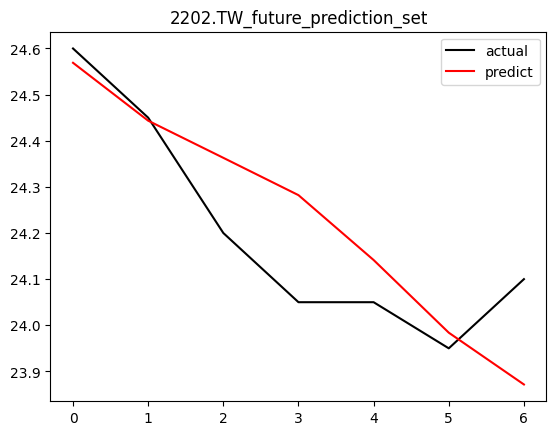

In [50]:

test_data_start= dt.datetime(2024,2,29)
test_data_end = dt.datetime(2024,3,11)
predi_data = yf.download(company, test_data_start, test_data_end)
##determine the columns of data##
df=predi_data[['Close']]
print(df.head())

print(type(next_day_prediction))
print(type(df))

array = df.values

# print(array)
print(type(array))
print(future_pred)

plt.plot(array, color='black', label=f'actual')
plt.plot(future_pred, color='red', label=f'predict')
plt.title(f"2202.TW_future_prediction_set")
plt.legend()
plt.show()
